In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

from edward.models import Normal, Poisson, Bernoulli, InverseGamma
import collections
import pandas as pd
import numpy as np

In [2]:
netw = pd.read_csv('/Users/oliver/Dropbox/EDU/DTU/Blockchain-Transaction-Classification/Data/network_subsample_2.csv', sep=",", header=0)

In [3]:
#Editing data:
netw_uniq = netw[netw['userID_send'] != netw['userID_recv']]                                            #Removing all users who sent to themselves
netw_uniq = netw_uniq.drop_duplicates(subset=['userID_send','userID_recv'], keep='last', inplace=False)  #Removing identical pairs, keeping the last ones

#Finding x% last made links:
netw_uniq=netw_uniq.sort_values(by='unixtime', axis=0, ascending=True)
unix = int(np.round(len(netw_uniq)*0.99))
sort = netw_uniq.iloc[unix][1] #sort er en numpy funktion navn TJEK!!!!!

#Creating subset:
data = netw_uniq #Creating a subset

#Editing matrix:
#from: https://stackoverflow.com/questions/49095067/how-to-convert-weighted-edge-list-to-adjacency-matrix-in-python
data.drop(['tx_id'], axis=1)                                                                            #Dropping column w. tx_id                                                      #Rearraning columns
data = data[['userID_send','userID_recv','unixtime']]                                                                                         #Implementing rearranging


#data.rename(index=str, columns={"userID_send": "0", "userID_recv": "1", "unixtime": "2"})               #Renaming columns

In [4]:
nodes = data.iloc[:, 0].tolist() + data.iloc[:, 1].tolist()
nodes = sorted(list(set(nodes)))
nodes = [(i,nodes[i]) for i in range(len(nodes))]
for i in range(len(nodes)): # for loops burde skiftes ud med map() funktion
    data = data.replace(nodes[i][1], nodes[i][0])

from scipy.sparse import coo_matrix
M = coo_matrix((data.iloc[:,2], (data.iloc[:,0],data.iloc[:,1])), shape=(len(nodes), len(nodes)))
M_zeroing = M.todense()
M_fullData = M.todense()
M_originalZero= M.todense()

#Creating correct indexes in adjecency matrix:
#Original dataset, with all links in adjacency matrix.
M_fullData[M_fullData>0]=1                        #Making all non-zeros into ones
OnesBeforeZeroing=(M_fullData>0).sum()                              #Number of 1'nes before sort= 125944

#Before touching:
(M_fullData>sort).sum()  #=1258
(M_fullData==0).sum()    #=99255017
(M_fullData>0).sum()    #= 125944
#Stats are same afterwards


#Adjecency matrix with only 99% of links:
M_zeroing[M_zeroing>sort]= 0                          #Making all the last 1% into zeros
M_zeroing[M_zeroing>0]=1                              #Making all non-zeros into ones
OnesAfterZeroing=(M_zeroing>0).sum()                              #Number of 1'nes after sort =124686

#Before running 61-63:
(M_zeroing>sort).sum()  #=1258
(M_zeroing==0).sum()    #=99255017
(M_zeroing>0).sum()     #=125944
#After:
(M_zeroing>sort).sum()  #=0
(M_zeroing==0).sum()    #=99256275 (=99255017+1258)
(M_zeroing>0).sum()     #=124686 (125944-1258)

percentage = OnesAfterZeroing/OnesBeforeZeroing                                #Checking the number fits with 1%

#Creating dataset consisting of only ones we have removed:
M_onesRemoved= M_fullData-M_zeroing
(M_onesRemoved>0).sum() #=1258

#Creating a dataset consisting of only the correct zero's - same amount as correct ones (=1258)
(M_originalZero==0).sum()
(M_originalZero==1).sum()
M_originalZero[M_originalZero>0]=1

In [5]:
#Defining variables and model:
x_train = M_zeroing

M_fullDataA = M_fullData
M_onesRemovedA = M_onesRemoved

In [7]:
N = x_train.shape[0]  # number of data points
K = 3  # latent dimensionality

scale_z = InverseGamma(tf.ones([1,K])*1e-3, tf.ones([1,K])*1e-3) 
scale_b = InverseGamma([1e-3], [1e-3]) #Gelman 2006

z2 = Normal(loc = tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K]))) #Tjek søjle
z1 = Normal(loc = tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K])))       
b = Normal(loc = tf.zeros(1), scale = (tf.sqrt(scale_b)*tf.ones(1)))

pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keepdims=True), [1, N])
pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keepdims=True), [1, N])        
           
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)

pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))

pi3 = tf.sigmoid(pi + b)

x = Bernoulli(probs = pi3)

In [8]:
qz1 = Normal(loc=tf.get_variable("qz1/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz1/scale", [N, K])))
qz2 = Normal(loc=tf.get_variable("qz2/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz2/scale", [N, K])))
qb = Normal(loc=tf.get_variable("qb/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qb/scale", 1)))

qscale_z = Normal(loc=tf.get_variable("qscale_z/loc", [1, K]),
             scale=tf.nn.softplus(tf.get_variable("qscale_z/scale", [1, K])))

qscale_b = Normal(loc=tf.get_variable("qscale_b/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qscale_b/scale", 1)))

inference = ed.KLqp({z1: qz1,
                     z2: qz2,
                     scale_z: qscale_z,
                     scale_b: qscale_b,
                     b: qb},
                     data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [9]:
inference.initialize(n_iter=20,logdir='log')

tf.global_variables_initializer().run()

info_loss = np.zeros(20)


for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  info_loss[_] = info_dict['loss']

inference.finalize()

In [10]:
sess = ed.get_session()
x_post = ed.copy(pi3, {z1: qz1,
                     z2: qz2,
                     scale_z: qscale_z,
                     scale_b: qscale_b,
                     b: qb})
x_gen = sess.run(x_post)

In [1]:
#Getting pi for M_onesRemoved:
M_onesRemovedtf= tf.convert_to_tensor(M_onesRemovedA, np.float32)
pi_onesRemoved= tf.multiply(M_onesRemovedtf,x_gen) #ændret her !!!!!
pi_onesRemoved_matrix= pi_onesRemoved.eval()
pi_onesRemoved_array=np.asarray(pi_onesRemoved_matrix).reshape(-1)
pi_onesRemoved_array=pi_onesRemoved_array[pi_onesRemoved_array!=0]          #All probabilities for ones_removed
nrOfZeros=len(pi_onesRemoved_array)

#Getting pi for M_fulldata
M_fullDataA= np.asarray(pi_onesRemoved_matrix).reshape(-1)
where_zero=np.where(M_fullDataA==0)[0]
where_zero_index=np.random.choice(where_zero,nrOfZeros)
pi_zeros= x_gen #ændret her !!!!!!
pi_array= np.asarray(pi_zeros).reshape(-1)
pi_originalZeros=pi_array[where_zero_index]                                 #All probabilities for correct zeros

Creating arrays with zeros and ones:
zeros=np.zeros(nrOfZeros)
ones=np.ones(nrOfZeros)
#Setting together:
y_test= np.concatenate((zeros, ones), axis=0)
p = np.concatenate((pi_originalZeros, pi_onesRemoved_array), axis=0)

In [21]:
#Inserting ROC-method
#Inserting ROC-script (supposed to be imported):
from pylab import *
from scipy.io import loadmat
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
#from toolbox_02450 import rocplot, confmatplot

from sklearn import metrics
def rocplot(p, y):
    fpr, tpr, thresholds = metrics.roc_curve(y.ravel(),p.ravel())
    AUC = metrics.roc_auc_score(y.ravel(), p.ravel())
    plt.plot(fpr, tpr, 'r', [0, 1], [0, 1], 'k')
    plt.xlim([-0.01,1.01]); ylim([-0.01,1.01])
    plt.xlabel('False positive rate (1-Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.title('Receiver operating characteristic (ROC)\n AUC={:.3f}'.format(AUC))
    plt.show()
    return AUC#, tpr, fpr

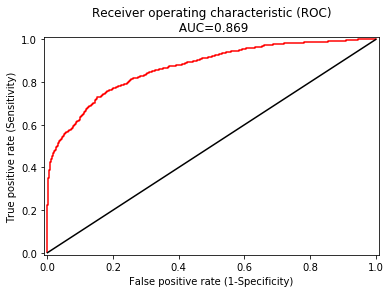

0.8689335786735954


In [22]:
print(rocplot(p, y_test))